# Testing mean (pseudo-) power spectrum computation



In [1]:
from pathlib import Path
from functools import partial
#import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, compute_mesh_power, compute_mean_mesh_power,
compute_normalization, generate_anisotropic_gaussian_mesh)

## With mesh

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)
edges = {'step': 0.005}

def make_callable(poles):
    toret = {}
    def get_fun(ill):
        return lambda k: jnp.interp(k, kin, poles[ill], left=0., right=0.)
    for ill, ell in enumerate(ells):
        toret[ell] = get_fun(ill)
    return toret

def gaussian_survey(boxsize=2000., meshsize=128, size=int(1e8), seed=random.key(42), scale=0.2, paint=False):
    # Generate Gaussian-distributed positions
    boxcenter = np.array((boxsize * 0.55, 0., 0.))
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * boxsize + boxcenter
    toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

def mock_survey(poles, selection, unitary_amplitude=True, los='local', seed=random.key(42)):
    # Generate Gaussian field
    mesh = generate_anisotropic_gaussian_mesh(make_callable(poles), unitary_amplitude=unitary_amplitude,
                                              boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                              los=los, seed=seed)

    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    mesh = mesh * selection
    return compute_mesh_power(mesh, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [3]:
gaussian_survey = jax.jit(gaussian_survey, static_argnames=['size', 'paint'])
selection = gaussian_survey(paint=True)

get_pk = lambda pkin, **kwargs: mock_survey(pkin, selection, unitary_amplitude=False, **kwargs)
get_pk = jax.jit(get_pk)

from tqdm import trange
pks = []
npk = 1000
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock + 1)
        pks.append(get_pk(poles, seed=seed))

def mean_survey(poles, selection, los='local'):
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    poles = make_callable(poles)
    if los == 'local': poles = (poles, los)  # local line-of-sight
    return compute_mean_mesh_power(selection, theory=poles, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)

mean = mean_survey(poles, selection)

100%|██████████| 1000/1000 [00:24<00:00, 41.35it/s]


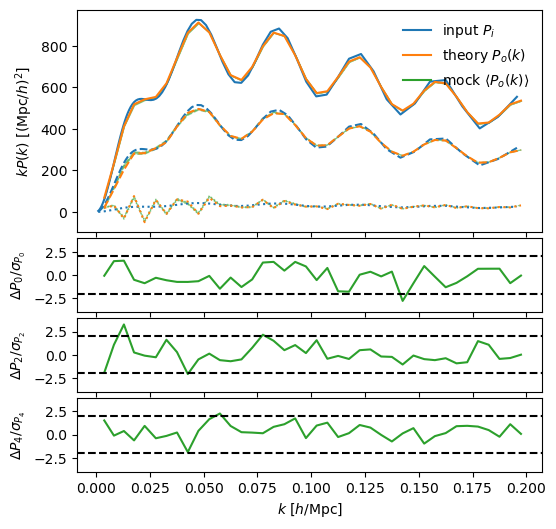

In [4]:
def plot(pks, mean):
    k, edges = pks[0].x(projs=0), pks[0].edges(projs=0)
    pk_mean, pk_std = np.mean([np.array(pk.value).real for pk in pks], axis=0), np.std([np.array(pk.value).real for pk in pks], axis=0) / npk**0.5
    
    height_ratios = [max(len(ells), 3)] + [1] * len(ells)
    figsize = (6, 1. * sum(height_ratios))
    fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
    fig.subplots_adjust(hspace=0.05)
    maskin = kin < edges[-1]
    linestyles = ['-', '--', ':']
    colors = ['C0', 'C1', 'C2']
    labels = ['input $P_i$', r'theory $P_o(k)$', r'mock $\langle P_o(k) \rangle$']
    ax = lax[0]
    for color, label in zip(colors, labels):
        ax.plot([], [], color=color, linestyle='-', label=label)
    for ill, ell in enumerate(ells):
        linestyle = linestyles[ill]
        ax.plot(kin[maskin], kin[maskin] * poles[ill][maskin], linestyle=linestyle, color=colors[0])
        ax.plot(k, k * mean.view(projs=ell).real, linestyle=linestyle, color=colors[1])
        kw = dict(lw=1., alpha=0.5)
        ax.fill_between(k, k * (pk_mean - pk_std)[ill], k * (pk_mean + pk_std)[ill], linestyle=linestyle, color=colors[2], **kw)
    ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.legend(frameon=False)
    for ill, ell in enumerate(ells):
        ax = lax[ill + 1]
        ax.plot(k, (pk_mean[ill] - mean.view(projs=ell).real) / pk_std[ill], color=colors[2])
        ax.set_ylim(-3., 3.)
        ax.set_ylim(-4, 4)
        for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
        ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
    lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    plt.show()

plot(pks, mean)

Agreement is perfect, as expected.

## FKP field, generating data / randoms particles

In [5]:
from jaxpower import FKPField, compute_fkp_power

def mock_survey_fkp(poles, unitary_amplitude=True, los='local', seed=random.key(42)):
    # Generate Gaussian field
    seeds = random.split(seed, 3)
    randoms = gaussian_survey(seed=seeds[0], size=int(1e7), paint=False)
    mesh = generate_anisotropic_gaussian_mesh(make_callable(poles), unitary_amplitude=unitary_amplitude,
                                              boxsize=randoms.boxsize, meshsize=randoms.meshsize, boxcenter=randoms.boxcenter,
                                              los=los, seed=seeds[2])
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    # weights = 1 + delta
    data = gaussian_survey(seed=seeds[1], size=int(1e7), paint=False)
    data = data.clone(weights=data.weights * (1. + mesh.read(data.positions, resampler='cic', compensate=True)))
    fkp = FKPField(data, randoms)
    return compute_fkp_power(fkp, edges=edges, resampler='tsc', interlacing=3, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=data.sum()**2 * norm)

In [6]:
norm = compute_normalization(selection, selection) / selection.sum()**2

get_pk = lambda pkin, **kwargs: mock_survey_fkp(pkin, unitary_amplitude=False, **kwargs)
get_pk = jax.jit(get_pk)

pks = []
npk = 1000
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock + 1)
        pks.append(get_pk(poles, seed=seed))

100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


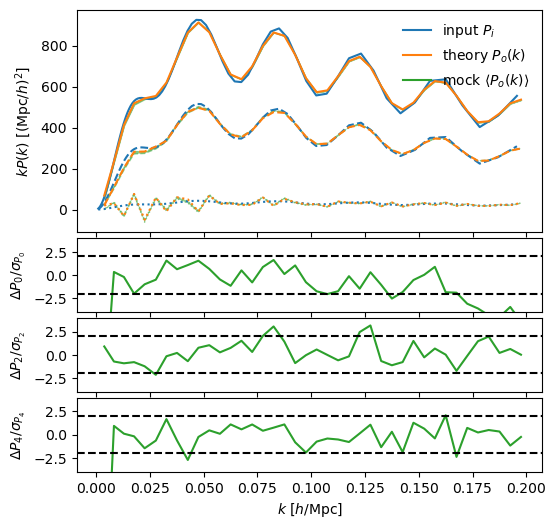

In [7]:
plot(pks, mean)

Remember that $k_\mathrm{nyq} = 0.2 \; [h/\mathrm{Mpc}]$... the agreement between theory and mocks is almost perfect up to that scale, at a precision of $1000$ realizations (which is somewhat surprising to me!). Something a bit weird at low $k$, maybe that's the global integral constraint effect?

In [8]:
def mock_survey_particles(poles, randoms, unitary_amplitude=True, los='local', seed=random.key(42)):
    # Generate Gaussian field
    mesh = generate_anisotropic_gaussian_mesh(make_callable(poles), unitary_amplitude=unitary_amplitude,
                                              boxsize=randoms.boxsize, meshsize=randoms.meshsize, boxcenter=randoms.boxcenter,
                                              los=los, seed=seed)
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    # weights = 1 + delta
    data = randoms
    data = data.clone(weights=data.weights * (1. + mesh.read(data.positions, resampler='cic', compensate=True)))
    fkp = FKPField(data, randoms)
    shotnoise_nonorm = jnp.sum((data.weights - randoms.weights)**2)
    return compute_fkp_power(fkp, edges=edges, resampler='tsc', interlacing=3, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=data.sum()**2 * norm, shotnoise_nonorm=shotnoise_nonorm)

In [9]:
randoms = gaussian_survey(paint=False)

get_pk = lambda pkin, *args, **kwargs: mock_survey_particles(pkin, *args, unitary_amplitude=False, **kwargs)
get_pk = jax.jit(get_pk)

pks = []
npk = 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock + 1)
        pks.append(get_pk(poles, randoms, seed=seed))

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


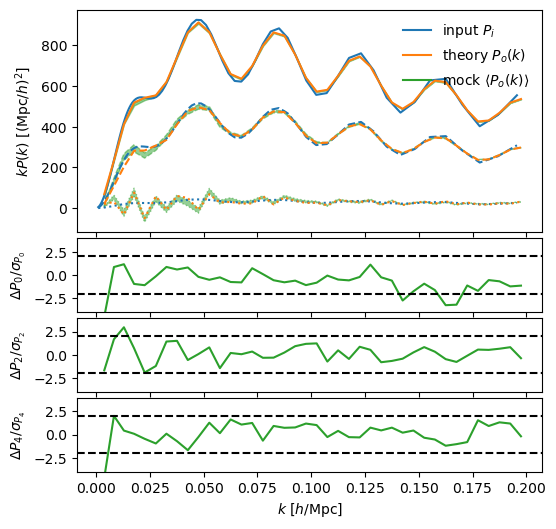

In [10]:
plot(pks, mean)